In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from dateutil.parser import parse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from hurst import compute_Hc
from datetime import date
import os
import datetime

In [2]:
# Import Data
df = pd.read_csv('NVD-Vulnerability-Volumes.csv',index_col=['Publication'],parse_dates=['Publication'],infer_datetime_format=True)
df.head()

,ID,ASSIGNER,DESCRIPTION,Count,v2 CVSS,v2 Vector,v2 Exploitability Score,v3 CVSS,v3 Vector,v3 Expoitability Score,CWE,MVUE,Delta with published
Publication,,,,,,,,,,,,,
1999-12-30 05:00:00+00:00,CVE-1999-0001,"""cve@mitre.org""","""ip_input.c in BSD-derived TCP/IP implementati...",1.0,5.0,"""AV:N/AC:L/Au:N/C:N/I:N/A:P""",NaN,NaN,NaN,NaN,"""CWE-20""",20003.0,13234.0
1998-10-12 04:00:00+00:00,CVE-1999-0002,"""cve@mitre.org""","""Buffer overflow in NFS mountd gives root acce...",1.0,10.0,"""AV:N/AC:L/Au:N/C:C/I:C/A:C""",NaN,NaN,NaN,NaN,"""CWE-119""",20003.0,13234.0
1998-04-01 05:00:00+00:00,CVE-1999-0003,"""cve@mitre.org""","""Execute commands as root via buffer overflow ...",1.0,10.0,"""AV:N/AC:L/Au:N/C:C/I:C/A:C""",NaN,NaN,NaN,NaN,"""NVD-CWE-Other""",20003.0,13234.0
1997-12-16 05:00:00+00:00,CVE-1999-0004,"""cve@mitre.org""","""MIME buffer overflow in email clients, e.g. S...",1.0,5.0,"""AV:N/AC:L/Au:N/C:N/I:N/A:P""",NaN,NaN,NaN,NaN,"""NVD-CWE-Other""",20003.0,13234.0
1998-07-20 04:00:00+00:00,CVE-1999-0005,"""cve@mitre.org""","""Arbitrary command execution via IMAP buffer o...",1.0,10.0,"""AV:N/AC:L/Au:N/C:C/I:C/A:C""",NaN,NaN,NaN,NaN,"""NVD-CWE-Other""",20003.0,13234.0


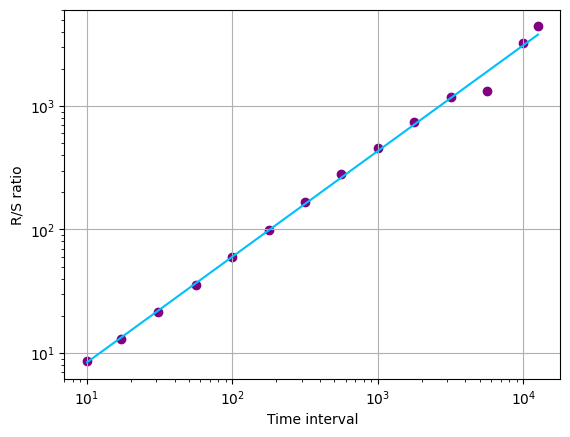

H=0.8559, c=1.1694


In [3]:
#Examine the data with the Hurst component to convinces ourselves this is possible (and lo0k at different timeframes of possibility)
H, c, data = compute_Hc(df['Count'].resample('D').sum(), kind='change',simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

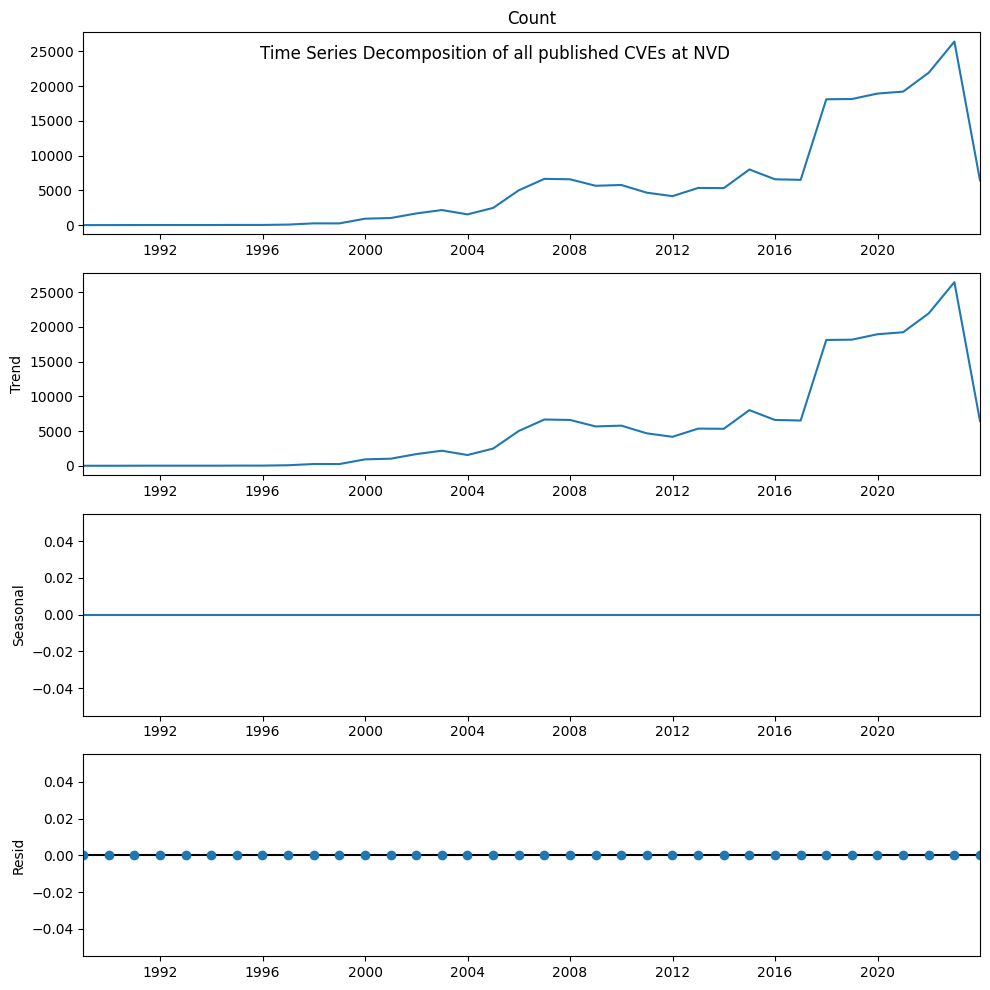

In [4]:
# Decompose 
result = seasonal_decompose(df['Count'].resample('Y').sum(), model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result.plot().suptitle('Time Series Decomposition of all published CVEs at NVD', y=0.95)
plt.show()

In [5]:
#Given our naive decomposition shows promise, let's go with STL since it can handle all kinds of seasonality
#We also must use additive since we have periods of zero in our data, so STL will fit the task
#stl_result = STL(df['Count'].resample('Y').sum()).fit()
#chart = stl_result.plot()
#plt.show()

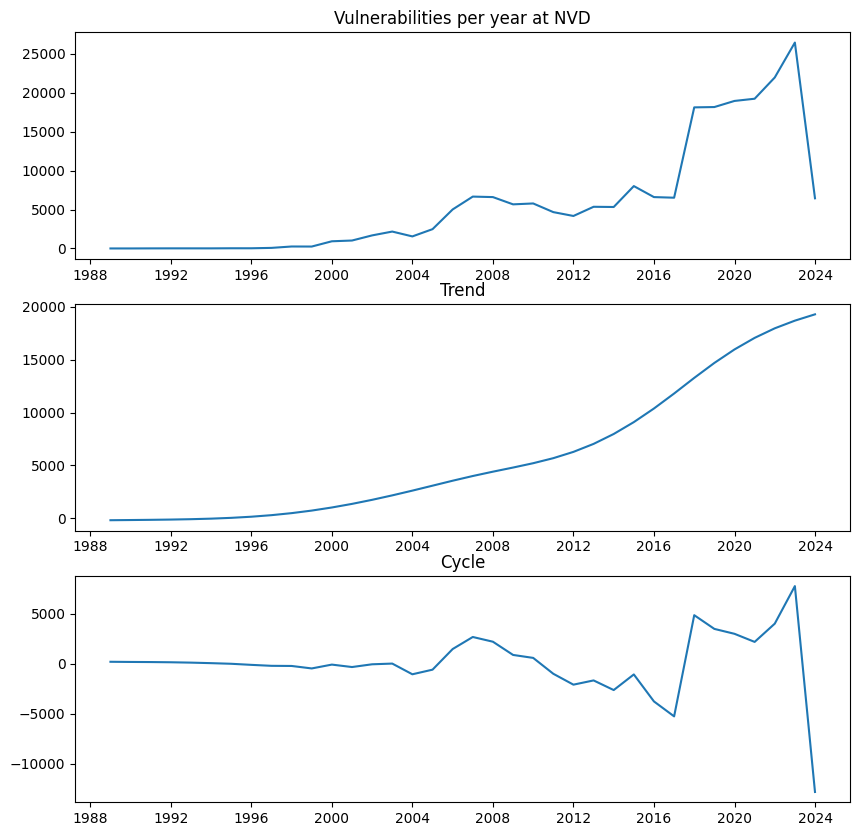

In [6]:
cycle, trend = sm.tsa.filters.hpfilter(df['Count'].resample('Y').sum(), 100) #100 for yearly, quarterly is 1600, monthly 129600, #weekly 33177600.
fig, ax = plt.subplots(3,1)
ax[0].plot(df['Count'].resample('Y').sum())
ax[0].set_title('Vulnerabilities per year at NVD')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()

/home/praxis/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


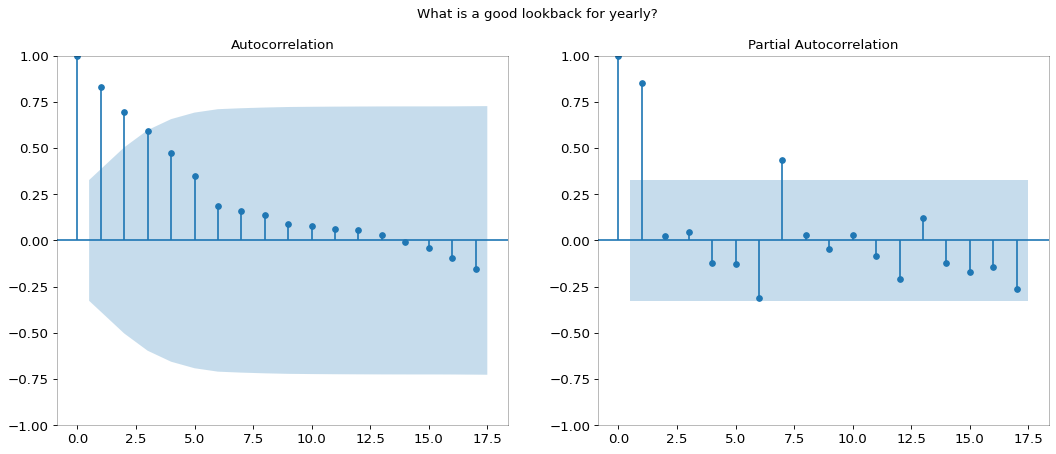

In [7]:
# Import Data
#df = all_vulns

# Draw Plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(df['Count'].resample('Y').sum().tolist(), ax=ax1, lags=17)
plot_pacf(df['Count'].resample('Y').sum().tolist(), ax=ax2, lags=17)

# Decorate
# lighten the borders
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

# font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
fig.suptitle("What is a good lookback for yearly?")
plt.show()

Test for trend MSE: 139.94159420178536


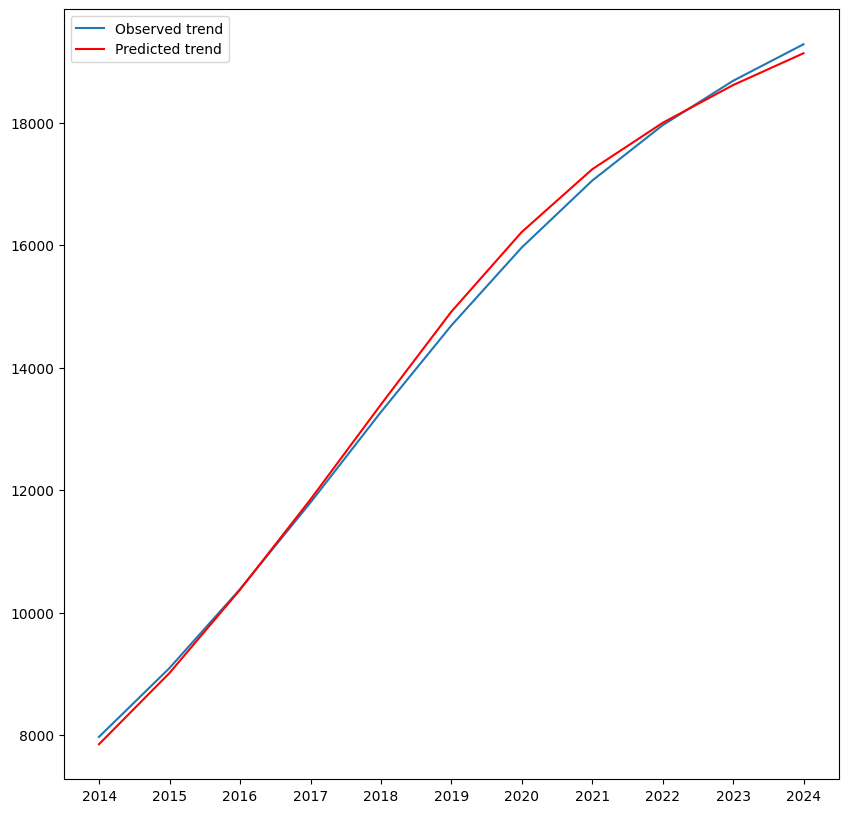

Test for cycle MSE: 6854.687783814635


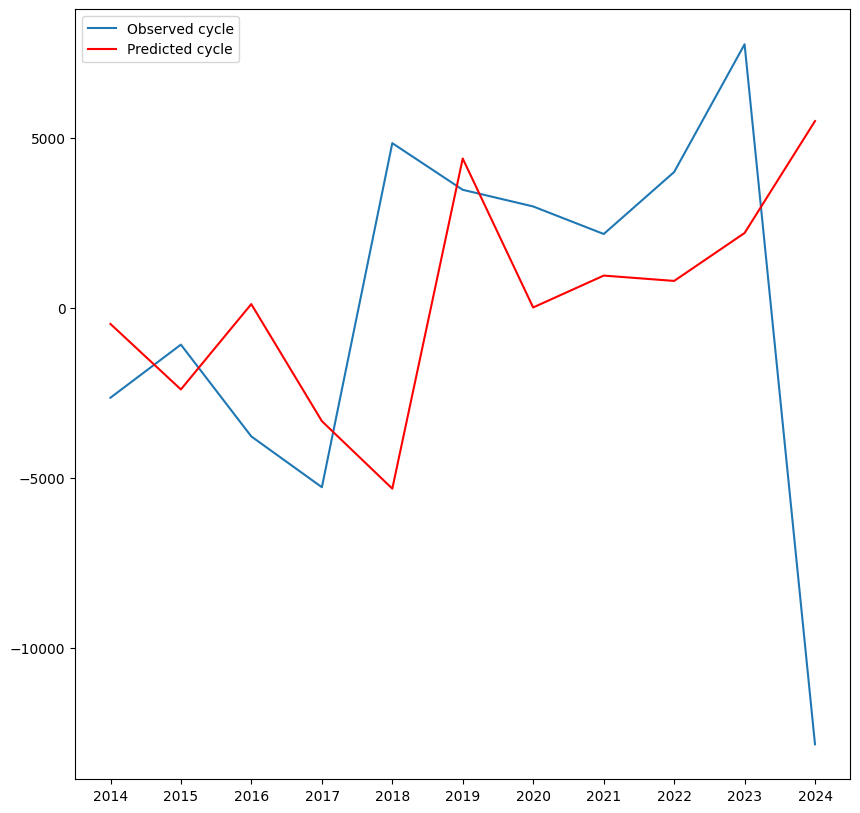

In [8]:
#Given we think it is predictable...let's try simple autoregression
component_dict = {'cycle': cycle, 'trend': trend}
prediction_results = []
for component in ['trend', 'cycle']:
    #Remove the one behind predictions
    historic = component_dict[component].iloc[:int(len(df['Count'].resample('Y').sum()) * 0.7)].to_list()
    test = component_dict[component].iloc[int(len(df['Count'].resample('Y').sum()) * 0.7):]
    predictions = []
    for i in range(len(test)):
        #2 here comes from our autocorrelation graph
        model = AutoReg(historic, lags=2, seasonal=False,period=1).fit()
        pred = model.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])
    predictions = pd.Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(test, predictions))
    print(f'Test for {component} MSE: {test_score}')
    # plot results
    plt.plot(test.iloc[:], label='Observed '+component)
    plt.plot(predictions.iloc[:], color='red', label='Predicted '+component)
    plt.legend()
    plt.show()

In [9]:
#This forecast needs to be combined with a mean I think
model.forecast(steps=2)

array([5491.00768025, 3782.19217968])

In [10]:

cutoff = datetime.datetime(datetime.datetime.now().year-1, 12, 31, 0, 0) 
#We'll want to check our progress through the quarter so we do need that as a data set later
check=df[df.index.tz_localize(None)>cutoff]
df=df[df.index.tz_localize(None)<=cutoff]
# Construct the model
#Didn't improve the model...maybe little's law would?
exog=df['MVUE'].resample('Y').max().fillna(method='bfill')
#mod = sm.tsa.SARIMAX(df['Count'].resample('Y').sum(), order=(1, 2, 1), exog=exog, trend='ct',time_varying_regression=True,mle_regression=False)
mod = sm.tsa.SARIMAX(df['Count'].resample('Y').sum(), order=(1, 2, 1), exog=None, trend='ct')
# Estimate the parameters
res = mod.fit()

print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85902D+00    |proj g|=  3.08689D-01

At iterate    5    f=  8.67435D+00    |proj g|=  6.55246D-03

At iterate   10    f=  8.64157D+00    |proj g|=  1.98268D-01

At iterate   15    f=  8.60416D+00    |proj g|=  4.70119D-03

At iterate   20    f=  8.60285D+00    |proj g|=  3.23897D-04

At iterate   25    f=  8.60282D+00    |proj g|=  1.24969D-03

At iterate   30    f=  8.56055D+00    |proj g|=  9.91178D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


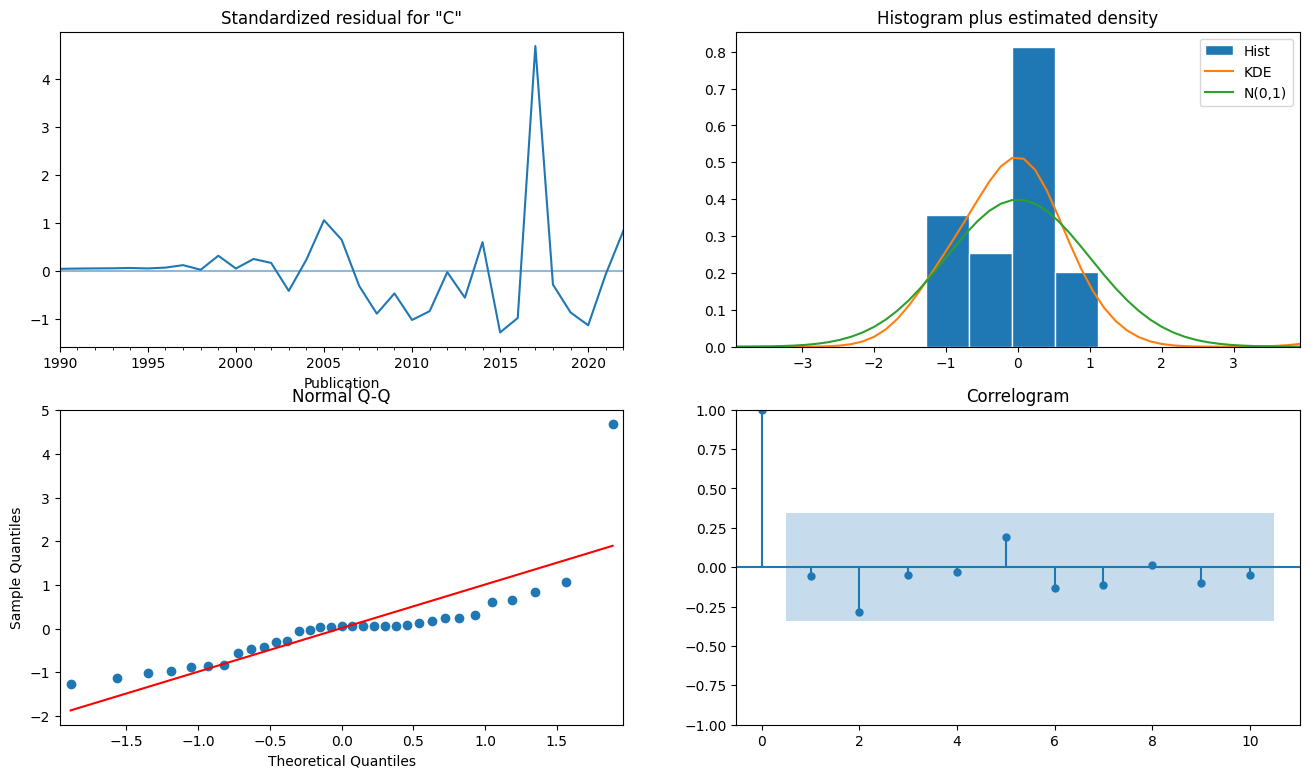

In [11]:
# Plot diagnostics
res.plot_diagnostics(figsize=(16, 9))
plt.show()

In [12]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(steps=2)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.05))

Count                              mean      mean_se  mean_ci_lower  \
2023-12-31 00:00:00+00:00  29172.307671  2070.327347   25114.540635   
2024-12-31 00:00:00+00:00  32443.894573  2751.651333   27050.757064   

Count                      mean_ci_upper  
2023-12-31 00:00:00+00:00   33230.074707  
2024-12-31 00:00:00+00:00   37837.032083  


In [13]:
today = date.today()
current_datetime = today.strftime("%b-%d-%Y")
#Note this format will overwrite all forecasts produced on the same day
file_name = current_datetime+"-Yearly-vuln4cast.csv"
path = 'YearlyForecasts/'
fcast_res1.summary_frame(alpha=0.05).to_csv(path+file_name)

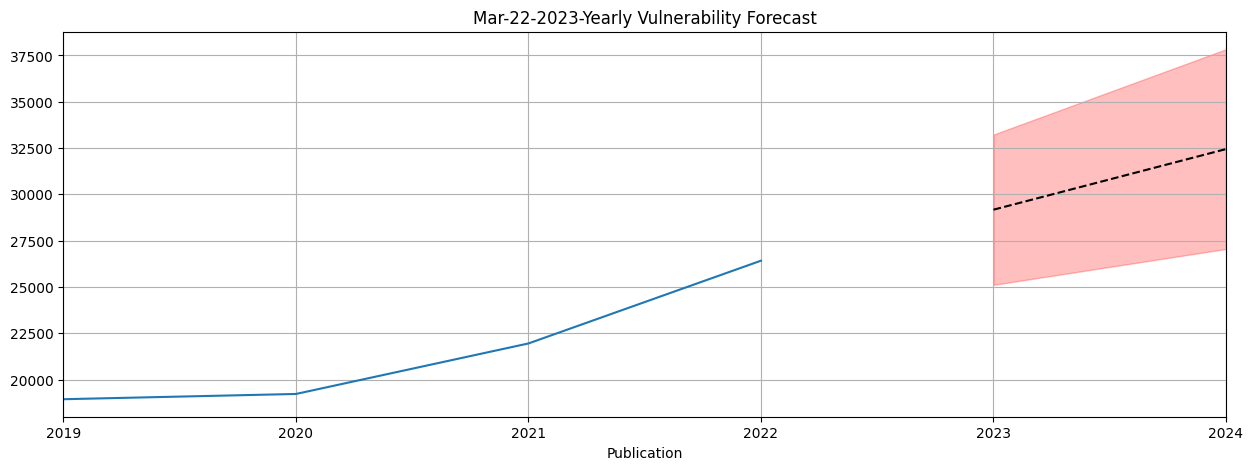

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.title(current_datetime+"-Yearly Vulnerability Forecast")

# Plot the data (here we are subsetting it to get a closer look at the forecasts than the history)
df['Count'].resample('Y').sum().loc['2019':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(steps=2).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='r', alpha=0.25);
ax.grid()
image_name = current_datetime+"-Yearly-vuln4cast.png"
plt.savefig(path+image_name)

In [15]:
#Now check how we're doing so far...
print(fcast_res1.summary_frame(alpha=0.05))
print('The current count of published NVD vulns is: '+str(check['Count'].sum()))

Count                              mean      mean_se  mean_ci_lower  \
2023-12-31 00:00:00+00:00  29172.307671  2070.327347   25114.540635   
2024-12-31 00:00:00+00:00  32443.894573  2751.651333   27050.757064   

Count                      mean_ci_upper  
2023-12-31 00:00:00+00:00   33230.074707  
2024-12-31 00:00:00+00:00   37837.032083  
The current count of published NVD vulns is: 6452.0
